In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import tensorflow_datasets as tfds

# 데이터 불러오기

In [2]:
# train, test 데이터 불러오기

train_path = './data/train.csv' # 필요에 따라 변경하세요.
test_path = './data/test.csv' # 필요에 따라 변경하세요.
train_normal_data_path = './data/일반대화 합성데이터(GPT-4o, AIhub 참고).csv'

def load_data(file_path):
    df = pd.read_csv(file_path)
    
    return df

train_df = load_data(train_path)
test_df = load_data(test_path)
normal_df = load_data(train_normal_data_path)

In [3]:
# 데이터 확인
train_df.shape, test_df.shape, normal_df.shape

((3950, 3), (500, 2), (1000, 3))

In [4]:
# train data 와 normal 데이터 합치기
def concat_train_normal(train_df, normal_df):
    train_df = pd.concat([train_df, normal_df], ignore_index=True)
    train_df.drop(['idx'], axis=1, inplace=True)
    train_df.reset_index(inplace=True)

    return train_df

train_df = concat_train_normal(train_df, normal_df)
train_df.head()

,index,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [5]:
# 클래스 숫자로 변환
def class_encoding(train_df, class_mapping):
    train_df['class_encoded'] = train_df['class'].replace(class_mapping)
    
    return train_df

# 클래스 매핑 딕셔너리 정의
class_mapping = {
    "협박 대화": 0,
    "갈취 대화": 1,
    "직장 내 괴롭힘 대화": 2,
    "기타 괴롭힘 대화": 3,
    "일반 대화": 4
}

train_df = class_encoding(train_df, class_mapping)

# 변환된 데이터 확인
train_df.head()


,index,class,conversation,class_encoded
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,0
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,0
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,3
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,1
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,1


# 전처리

In [6]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower().strip()

  # 개행 문자("\n")를 공백으로 변환
  sentence = re.sub(r"\n", " ", sentence)
    
  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # ?.!, 앞뒤로 공백 추가
  sentence = re.sub(r'[" "]+', " ", sentence) # 연속된 공백 한개의 공백으로

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z\u1100-\u11FF\uAC00-\uD7AF.,?!]", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [7]:
conversation = train_df['conversation'].apply(preprocess_sentence)
conversation

0       지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...
1       길동경찰서입니다 .  시   분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...
2       너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...
3       어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...
4       저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 이 선크림 파는데 한 번 손등에...
                              ...                        
4945    요즘 나는 축구 배워보고 싶다 키키 축구 ? 축구 룰에 대해서는 알아 ? 오오 알지...
4946    프로게이머들은 좋아하는 거 하고 돈 버니까 좋겠다 키키 부럽 . 임요한 진짜 돈 많...
4947    너는 해외여행 자주 다니는 편이야 ? 키키 아니 . 비행기 타는 걸 안 좋아해서 해...
4948    겨울에 눈이 제발 적게 오면 좋겠다 나도 키키 어릴 땐 눈 오는 게 되게 좋아했었는...
4949    요즘은 비나 태풍이 한번 와도 피해가 큰 듯 어    나는 아직 태풍 매미를 잊지 ...
Name: conversation, Length: 4950, dtype: object

In [8]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(conversation, target_vocab_size=2**13)

In [9]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8215


In [10]:
# 1998번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 1998번째 질문 샘플: {}'.format(tokenizer.encode(conversation[1998])))

정수 인코딩 후의 1998번째 질문 샘플: [7, 5, 202, 1007, 54, 86, 3536, 7989, 52, 558, 1, 35, 8, 243, 1373, 6, 19, 5949, 7989, 263, 8193, 8113, 8136, 209, 827, 181, 1, 7, 5, 1121, 4290, 13, 2471, 1, 24, 171, 5708, 1102, 18, 219, 43, 1373, 244, 1744, 214, 1, 1693, 1159, 5649, 1297, 3171, 3143, 102, 2, 9, 7, 5, 39, 1158, 693, 341, 236, 2726, 7989, 443, 1342, 17, 2207, 1, 606, 482, 296, 296, 62, 1, 39, 100, 267, 54, 1443, 2, 45, 1, 1788, 4805, 178, 1, 8, 39, 314, 1980, 30, 480, 133, 1, 6507, 1, 14, 2193, 1033, 63, 1, 8, 39, 78, 498, 1, 7029, 257, 100, 711, 6637, 169, 1, 82, 43, 52, 1517, 450, 4046, 938, 1, 39, 174, 3832, 1158, 693, 408, 848, 194, 7643, 1, 7, 4263, 7989, 52, 19, 518, 7, 2361, 4138, 7989, 204, 7301, 103, 1, 1198, 6, 8191, 8142, 8095, 1763, 71, 61, 4259, 2618, 28]


In [11]:
# 원본 확인
conversation[1998].split()

['너',
 '내가',
 '좋은',
 '말로',
 '할',
 '때',
 '빌린',
 '돈',
 '내놔',
 '.',
 '아니',
 '나',
 '아직',
 '월급이',
 '안',
 '들어와서',
 '여윳돈이',
 '없다구',
 '.',
 '너',
 '내가',
 '처음',
 '이러는',
 '거',
 '아니잖아',
 '.',
 '왜',
 '사람',
 '화나게',
 '하냐고',
 '너는',
 '내',
 '월급날',
 '모르잖아',
 '.',
 '알려줬는데도',
 '매일',
 '사람한테',
 '이럴거야',
 '?',
 '야',
 '너',
 '내가',
 '지금',
 '칼',
 '들고',
 '너네',
 '원룸',
 '앞으로',
 '간다',
 '!',
 '새끼야',
 '.',
 '어이',
 '친구',
 '살살해',
 '.',
 '지금',
 '그게',
 '사람이',
 '할',
 '소리야',
 '?',
 '야',
 '.',
 '전화',
 '끊어봐',
 '.',
 '나',
 '지금',
 '차',
 '돌려서',
 '가고',
 '있어',
 '.',
 '잠깐만',
 '.',
 '진짜',
 '오고',
 '있냐고',
 '.',
 '나',
 '지금',
 '못',
 '나가',
 '.',
 '여자친구랑',
 '있어',
 '그게',
 '뭔',
 '상관인데',
 '.',
 '나는',
 '내',
 '돈',
 '받으러',
 '가겠다고',
 '.',
 '지금',
 '주머니칼',
 '들고',
 '갈테니까',
 '알아서해',
 '.',
 '너',
 '죽일거야',
 '돈',
 '안',
 '주면',
 '너',
 '경찰',
 '신고하기',
 '전에',
 '곱게',
 '자',
 '.',
 '밤이',
 '깊었는데',
 '뭐',
 '하고',
 '지랄이냐',
 '.']

In [12]:
# 각 데이터의 토큰 개수 세기
temp = list(map(lambda x : len(x.split()), conversation))
temp[:5]

[69, 51, 67, 44, 140]

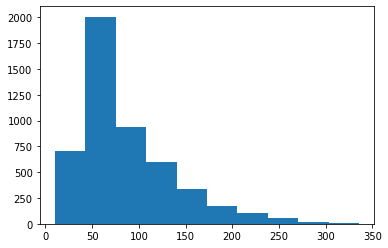

In [13]:
# 각 데이터의 토큰 개수 시각화 - histplot
import matplotlib.pyplot as plt

plt.hist(temp)
plt.show()

In [14]:
print(f'MAX_LENGTH = 200 일때: {np.array([True if x <= 200 else False for x in temp]).sum() / len(conversation) * 100:.2f} %')
print(f'MAX_LENGTH = 100 일때: {np.array([True if x <= 100 else False for x in temp]).sum() / len(conversation) * 100:.2f} %')
print(f'MAX_LENGTH = 50 일때: {np.array([True if x <= 50 else False for x in temp]).sum() / len(conversation) * 100:.2f} %')

MAX_LENGTH = 200 일때: 95.90 %
MAX_LENGTH = 100 일때: 71.13 %
MAX_LENGTH = 50 일때: 24.38 %


In [15]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 100
print(MAX_LENGTH)

100


In [16]:
# 최대 길이를 초과하는 샘플은 데이터 자르기, 패딩
def tokenize_and_filter(inputs):
  tokenized_inputs = list()
  
  for sentence in inputs:
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence = tokenizer.encode(sentence)

    # 최대 길이 200 까지만 데이터셋으로 사용
    if len(sentence) <= MAX_LENGTH:
      tokenized_inputs.append(sentence)
    
    else:
      tokenized_inputs.append(sentence[:MAX_LENGTH])
  
  # 최대 길이 200으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs

In [17]:
conversation = tokenize_and_filter(conversation)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 대화 샘플 개수: {}'.format(len(conversation)))

단어장의 크기 : 8215
필터링 후의 대화 샘플 개수: 4950


# 모델링 - transformer 인코딩 모델 밑바닥부터 구현하기

In [18]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

# 멀티 헤드 어텐션 구현하기
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

# 패딩 마스크 구현 함수
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 인코더 생성하기
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [19]:
# 인코더만 구성하기
def my_encoder(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="my_encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # Global Average Pooling 적용 (or Max Pooling 가능)
  outputs = tf.keras.layers.GlobalMaxPooling1D()(enc_outputs)

  # 완전연결층
  outputs = tf.keras.layers.Dense(256, activation="relu", name='dense1')(outputs)
  outputs = tf.keras.layers.Dense(128, activation="relu", name='dense2')(outputs)
  outputs = tf.keras.layers.Dense(units=5, activation="softmax", name='outputs')(outputs)

  return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

In [20]:
# 모델 생성하기
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = my_encoder(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "my_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3157248     inputs[0][0]                     
                                                                 enc_padding_mask[0][0]           
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 256)          0           encoder[0][0]           

In [21]:
# 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping & ModelCheckpoint 설정
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

model_checkpoint = ModelCheckpoint(
    "best_model", monitor='val_loss', save_best_only=True, mode='max', verbose=1, save_format="tf", save_weights_only=True)

callbacks = [early_stopping, model_checkpoint]


In [23]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])

In [24]:
# 데이터셋 크기 확인
dataset_size = len(conversation)  # 입력 데이터 개수
train_size = int(0.6 * dataset_size)  # 80% 훈련 데이터
val_size = int(0.2 * dataset_size)  # 10% 검증 데이터
test_size = dataset_size - train_size - val_size  # 10% 테스트 데이터

# 데이터셋 생성
BATCH_SIZE = 64
BUFFER_SIZE = 10000

# TensorFlow Dataset 생성
dataset = tf.data.Dataset.from_tensor_slices((
    {'inputs': conversation},  # 입력 데이터
    {'outputs': train_df['class_encoded'].values}  # 출력 데이터 (라벨)
))

dataset = dataset.cache().shuffle(BUFFER_SIZE)

# 데이터셋 분할
train_dataset = dataset.take(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = dataset.skip(train_size).take(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = dataset.skip(train_size + val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 데이터셋 크기 출력
print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")


Train size: 2970, Validation size: 990, Test size: 990


In [25]:
# 모델 학습
EPOCHS = 100
model.fit(train_dataset, 
          validation_data=val_dataset, 
          epochs=EPOCHS, 
          callbacks=callbacks)

Epoch 1/100
47/47 [==============================] - 5s 48ms/step - loss: 1.6296 - accuracy: 0.2101 - val_loss: 1.6044 - val_accuracy: 0.1980

Epoch 00001: val_loss improved from -inf to 1.60440, saving model to best_model
Epoch 2/100
47/47 [==============================] - 2s 37ms/step - loss: 1.5641 - accuracy: 0.2902 - val_loss: 1.5245 - val_accuracy: 0.2899

Epoch 00002: val_loss did not improve from 1.60440
Epoch 3/100
47/47 [==============================] - 2s 37ms/step - loss: 1.4861 - accuracy: 0.3660 - val_loss: 1.3912 - val_accuracy: 0.4253

Epoch 00003: val_loss did not improve from 1.60440
Epoch 4/100
47/47 [==============================] - 2s 37ms/step - loss: 1.3689 - accuracy: 0.3980 - val_loss: 1.2353 - val_accuracy: 0.5000

Epoch 00004: val_loss did not improve from 1.60440
Epoch 5/100
47/47 [==============================] - 2s 37ms/step - loss: 1.2008 - accuracy: 0.4717 - val_loss: 1.0935 - val_accuracy: 0.5061

Epoch 00005: val_loss did not improve from 1.60440
E

# Test dataset으로 확인하기

In [26]:
# 모델 평가 (train_dataset을 사용)
model.evaluate(train_dataset)

47/47 [==============================] - 1s 13ms/step - loss: 0.0036 - accuracy: 0.9993


[0.0036047231405973434, 0.9993265867233276]

In [27]:
# 모델 평가 (validation_dataset을 사용)
model.evaluate(val_dataset)

16/16 [==============================] - 0s 13ms/step - loss: 4.8779e-04 - accuracy: 1.0000


[0.0004877923638559878, 1.0]

In [28]:
# 모델 평가 (train_dataset을 사용)
model.evaluate(test_dataset)

16/16 [==============================] - 0s 13ms/step - loss: 0.0012 - accuracy: 1.0000


[0.0011597162811085582, 1.0]

In [29]:
# test_dataset에서 X, y 추출

# X와 y 리스트 생성
X_test = []
y_test = []

# test_dataset에서 inputs(X)와 outputs(y) 추출
for x, y in test_dataset:
    X_test.extend(x['inputs'].numpy())  # X 값 (입력 데이터)
    y_test.extend(y['outputs'].numpy())  # y 값 (라벨 데이터)

# 리스트를 NumPy 배열로 변환
X_test = np.array(X_test)
y_test = np.array(y_test)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_test shape: (990, 100)
y_test shape: (990,)


In [30]:
def get_pred(X_test):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=-1)
    
    return y_pred

y_pred = get_pred(X_test)
y_pred[:5]

array([4, 1, 2, 4, 4])

In [31]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       162
           1     1.0000    1.0000    1.0000       204
           2     1.0000    1.0000    1.0000       196
           3     1.0000    1.0000    1.0000       210
           4     1.0000    1.0000    1.0000       218

    accuracy                         1.0000       990
   macro avg     1.0000    1.0000    1.0000       990
weighted avg     1.0000    1.0000    1.0000       990



# 추론 및 Submission 저장

In [32]:
def make_submission_df(model, test_df):
    test_conversation = test_df['text'].apply(preprocess_sentence)
    test_conversation = tokenize_and_filter(test_conversation)
    
    y_pred = get_pred(test_conversation)
    
    test_df['target'] = y_pred
    test_df.drop(['text'], axis=1, inplace=True)
    
    return test_df

test_df = make_submission_df(model, test_df)
test_df.to_csv('my_submission.csv', index=False)
test_df.head()

,idx,target
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,2
4,t_004,3
